In [ ]:
# Import relevant packages
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid


In [2]:
# load dataset
data = pd.read_csv('../data/NF-UNSW-NB15-v3.csv')
data.head() 

,FLOW_START_MILLISECONDS,FLOW_END_MILLISECONDS,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,...,SRC_TO_DST_IAT_MIN,SRC_TO_DST_IAT_MAX,SRC_TO_DST_IAT_AVG,SRC_TO_DST_IAT_STDDEV,DST_TO_SRC_IAT_MIN,DST_TO_SRC_IAT_MAX,DST_TO_SRC_IAT_AVG,DST_TO_SRC_IAT_STDDEV,Label,Attack
0,1424242193040,1424242193043,59.166.0.2,4894,149.171.126.3,53,17,5.0,146,2,...,0,0,0,0,0,0,0,0,0,Benign
1,1424242192744,1424242193079,59.166.0.4,52671,149.171.126.6,31992,6,11.0,4704,28,...,0,91,12,19,0,90,12,19,0,Benign
2,1424242190649,1424242193109,59.166.0.0,47290,149.171.126.9,6881,6,37.0,13662,238,...,0,1843,10,119,0,1843,5,88,0,Benign
3,1424242193145,1424242193146,59.166.0.8,43310,149.171.126.7,53,17,5.0,146,2,...,0,0,0,0,0,0,0,0,0,Benign
4,1424242193239,1424242193241,59.166.0.1,45870,149.171.126.1,53,17,5.0,130,2,...,0,0,0,0,0,0,0,0,0,Benign


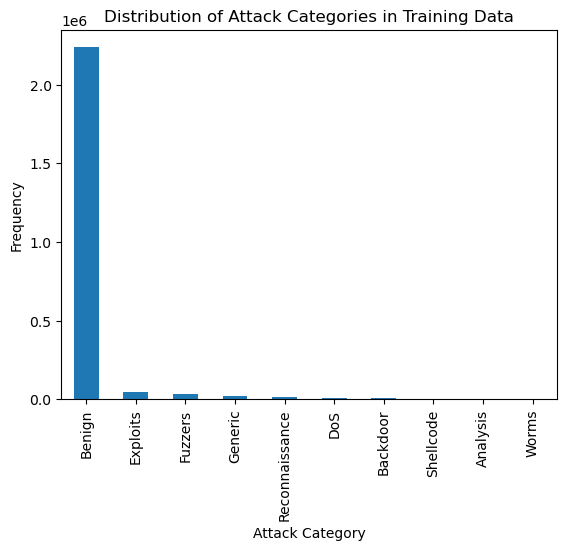

In [3]:
# Histogram of attack categories in dataset
data['Attack'].value_counts().plot(kind='bar')
plt.title('Distribution of Attack Categories in Training Data')
plt.xlabel('Attack Category')
plt.ylabel('Frequency')
plt.show()

Since benign data is overrepresented in this dataset, I will select a sample from that class to prevent model bias.

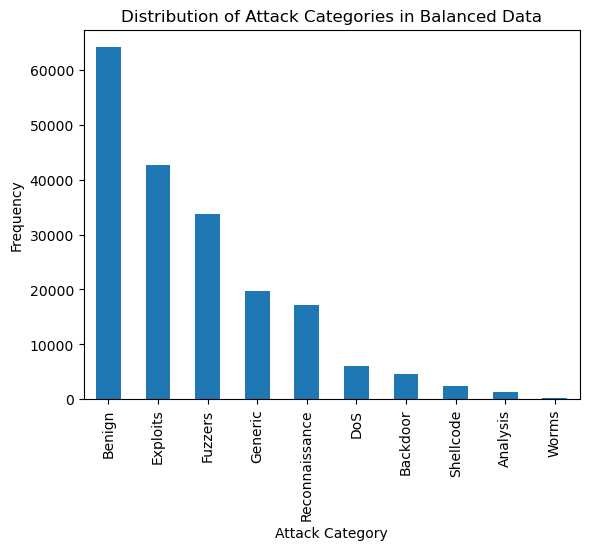

In [4]:
# Exploits is the second most frequent attack category after Benign.
# Benign data is set as 1.5 times the count of Exploits
benign_count = int(data['Attack'].value_counts()['Exploits'] * 1.5)

# Sample benign data to balance the dataset
benign_sample = data[data['Attack'] == 'Benign'].sample(benign_count, random_state=42)

# Keep all other classes as they are
others = data[data['Attack'] != 'Benign']

# Combine back to form a balanced dataset
balanced_data = pd.concat([benign_sample, others]).sample(frac=1, random_state=42).reset_index(drop=True)

# Visualize the balanced dataset
balanced_data['Attack'].value_counts().plot(kind='bar')
plt.title('Distribution of Attack Categories in Balanced Data')
plt.xlabel('Attack Category')
plt.ylabel('Frequency')
plt.show()

In [5]:
# Drop flow identifiers and TTL-based features to avoid bias
# Drop label column as it is redundant with Attack column
# Drop SRC_TO_DST_SECOND_BYTES and DST_TO_SRC_SECOND_BYTES due to high amount of inf and null values
drop_cols = [
    'FLOW_START_MILLISECONDS', 'FLOW_END_MILLISECONDS',
    'IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT',
    'MIN_TTL', 'MAX_TTL', 'Label', 'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES'
]

data_cleaned = balanced_data.drop(columns=drop_cols)
data_cleaned.head()

,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,...,FTP_COMMAND_RET_CODE,SRC_TO_DST_IAT_MIN,SRC_TO_DST_IAT_MAX,SRC_TO_DST_IAT_AVG,SRC_TO_DST_IAT_STDDEV,DST_TO_SRC_IAT_MIN,DST_TO_SRC_IAT_MAX,DST_TO_SRC_IAT_AVG,DST_TO_SRC_IAT_STDDEV,Attack
0,6,13.0,478,10,256,6,19,19,19,404,...,0,0,153,44,56,0,258,64,99,Fuzzers
1,6,0.0,528,10,8824,12,27,19,27,4,...,0,0,1,0,0,0,1,0,0,Benign
2,6,1.0,9,1,193,3,24,24,16,33,...,331,0,525,89,180,0,540,107,195,Benign
3,6,13.0,522,10,256,6,19,19,19,553,...,0,0,156,56,65,0,296,90,119,Fuzzers
4,17,5.0,114,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Generic


In [6]:
# Convert Attack labels to numerical values
label_mapping = {label: idx for idx, label in enumerate(data_cleaned['Attack'].unique())}

# Print the mapping for reference
print("Label to Attack mapping:")
for label, attack in label_mapping.items():
    print(f"{attack}: {label}")


Label to Attack mapping:
0: Fuzzers
1: Benign
2: Generic
3: Exploits
4: DoS
5: Backdoor
6: Analysis
7: Reconnaissance
8: Shellcode
9: Worms


In [7]:
# Apply the mapping to the Attack column
data_cleaned['Attack'] = data_cleaned['Attack'].map(label_mapping)
data_cleaned.head()

features = data_cleaned.drop(columns=['Attack'], axis=1)
labels = data_cleaned['Attack'] 

In [8]:

# Scale the features with min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler.fit_transform(features)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42, stratify=labels)


# Using a Random Forest Classifier

Random Forest accuracy: 0.8294971717540338
Classification report:
               precision    recall  f1-score   support

           0       0.67      0.89      0.76      6763
           1       1.00      1.00      1.00     12824
           2       0.92      0.88      0.90      3930
           3       0.77      0.76      0.76      8550
           4       0.63      0.29      0.40      1196
           5       0.42      0.09      0.15       932
           6       0.33      0.38      0.35       245
           7       0.77      0.65      0.70      3415
           8       0.70      0.59      0.64       476
           9       0.86      0.59      0.70        32

    accuracy                           0.83     38363
   macro avg       0.71      0.61      0.64     38363
weighted avg       0.83      0.83      0.82     38363



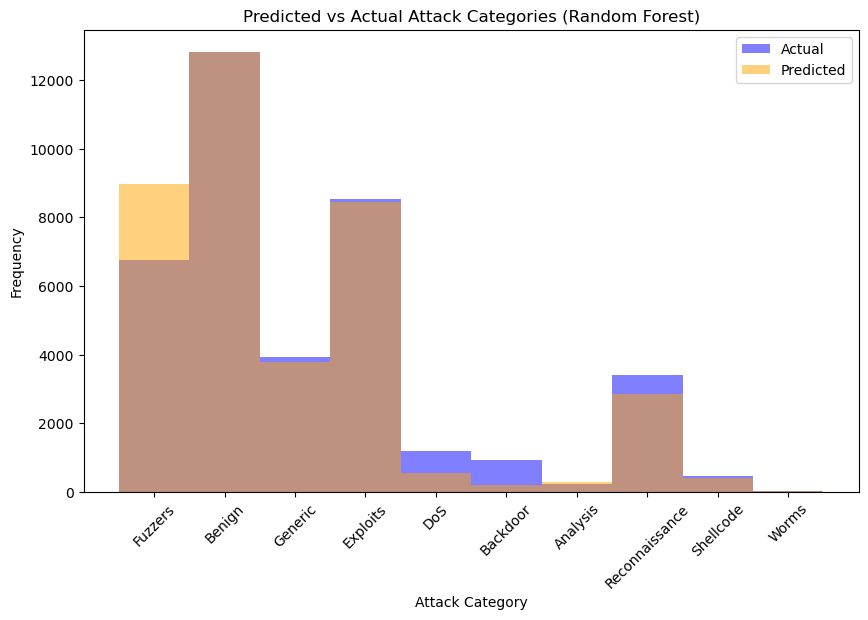

In [9]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on test set
y_rf_pred = rf.predict(X_test)

# Print accuracy
print("Random Forest accuracy:", accuracy_score(y_test, y_rf_pred))

# Print classification report
print("Classification report:\n", classification_report(y_test, y_rf_pred))

# Plot histogram of actual vs predicted categories
plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=np.arange(len(label_mapping)+1)-0.5, alpha=0.5, label='Actual', color='blue')
plt.hist(y_rf_pred, bins=np.arange(len(label_mapping)+1)-0.5, alpha=0.5, label='Predicted', color='orange')
plt.xticks(ticks=range(len(label_mapping)), labels=[label for label in label_mapping.keys()], rotation=45)
plt.xlabel('Attack Category')
plt.ylabel('Frequency')
plt.title('Predicted vs Actual Attack Categories (Random Forest)')
plt.legend()
plt.show()

# Using a simple neural network

In [ ]:
# Get the number of features for the input layer
num_features = X_train.shape[1]

# Define the model
tf.random.set_seed(1234)  # for consistent results

model = Sequential([
    tf.keras.Input(shape=(num_features,)),  
    Dense(64, activation='relu', name="L1"),          
    Dense(32, activation='relu', name="L2"),
    Dense(10, activation='linear', name="L3")      
], name="my_model")

model.summary()

In [ ]:
# Compile the model using softmax cross-entropy loss and Adam optimizer
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    metrics=['accuracy']

)

history = model.fit(X_train, y_train,
                    epochs=50,       # Number of passes through the entire dataset
                    batch_size=32,   # Number of samples per gradient update
                    validation_split=0.1) # Use a portion of training data for validation

In [11]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy*100}%')

1199/1199 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6663 - loss: 0.9910
Test Loss: 0.993008017539978, Test Accuracy: 66.68404340744019%


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step


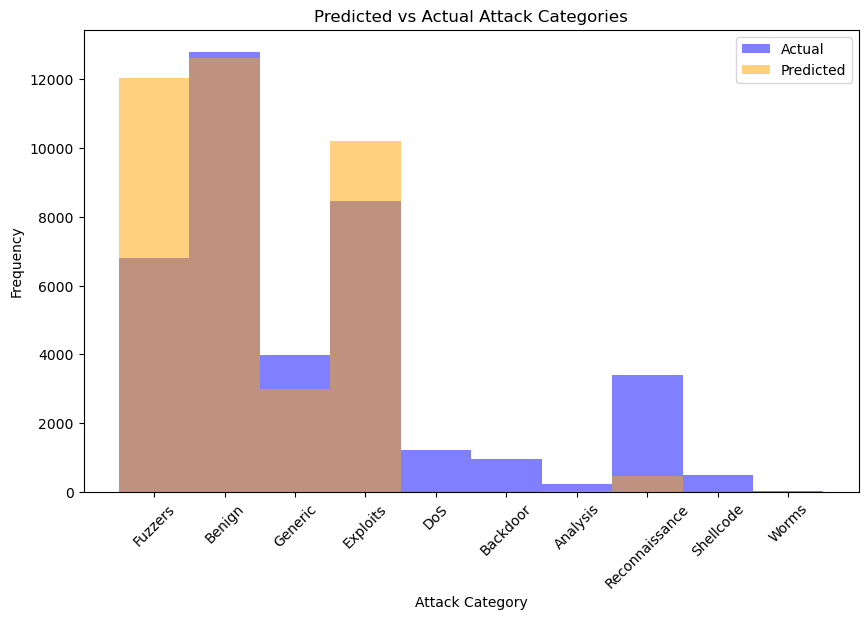

In [12]:
# Visualise predicted vs actual values in bar chart
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)     
plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=np.arange(len(label_mapping)+1)-0.5, alpha=0.5, label='Actual', color='blue')
plt.hist(y_pred_classes, bins=np.arange(len(label_mapping)+1)-0.5, alpha=0.5, label='Predicted', color='orange')
plt.xticks(ticks=range(len(label_mapping)), labels=[label for label in label_mapping.keys()], rotation=45)
plt.xlabel('Attack Category')
plt.ylabel('Frequency')
plt.title('Predicted vs Actual Attack Categories')
plt.legend()
plt.show()


